# Compare full spike lentivirus DMS data with yeast DMS data for Ly-CoV1404

In [1]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import natsort

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import yaml

In [2]:
warnings.simplefilter('ignore')

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [4]:
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))
plt.style.use('seaborn-white')

In [5]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

In [6]:
#read data
lenti_DMS = pd.read_csv(config['lenti_dms_lycov1404'])
yeast_DMS = pd.read_csv(config['yeast_dms_lycov1404_Star'])

In [7]:
a = ['214a' , '214b', '214c']
lenti_DMS = lenti_DMS[~lenti_DMS['site'].isin(a)]

lenti_DMS['site']=lenti_DMS['site'].astype(int)

## Compare to yeast DMS dataset

In [8]:
merged_DMS = pd.merge(yeast_DMS, lenti_DMS,  how='inner',
                      left_on=['site','wildtype', 'mutation'],
                      right_on = ['site','wildtype', 'mutant'])
merged_DMS

,condition,site,wildtype,mutation_x,mut_escape,site_total_escape,site_max_escape,epitope,mutant,mutation_y,escape_mean,escape_median,escape_std,n_models,times_seen,frac_models
0,LY-CoV1404 - BA1,331,N,D,0.011720,0.1646,0.02958,1,D,N331D,0.2803,0.0711,0.4805,4,3.2500,1.00
1,LY-CoV1404 - BA1,331,N,E,0.007214,0.1646,0.02958,1,E,N331E,-0.0198,-0.0222,0.0178,3,2.6667,0.75
2,LY-CoV1404 - BA1,331,N,H,0.008024,0.1646,0.02958,1,H,N331H,-0.0008,0.0072,0.0142,3,3.6667,0.75
3,LY-CoV1404 - BA1,331,N,K,0.014850,0.1646,0.02958,1,K,N331K,0.0192,0.0096,0.0284,4,2.2500,1.00
4,LY-CoV1404 - BA1,331,N,S,0.022960,0.1646,0.02958,1,S,N331S,0.0232,0.0070,0.0513,4,6.0000,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,LY-CoV1404 - BA1,530,S,I,0.008317,0.1846,0.01248,1,I,S530I,-0.0179,-0.0100,0.0218,3,1.6667,0.75
888,LY-CoV1404 - BA1,530,S,N,0.008328,0.1846,0.01248,1,N,S530N,-0.3006,-0.0419,0.5470,4,10.5000,1.00
889,LY-CoV1404 - BA1,530,S,V,0.007884,0.1846,0.01248,1,V,S530V,-0.0221,-0.0221,0.0090,2,5.0000,0.50
890,LY-CoV1404 - BA1,530,S,W,0.009851,0.1846,0.01248,1,W,S530W,-0.0362,-0.0362,NaN,1,1.0000,0.25


In [9]:
merged_DMS = merged_DMS[['site', 'mutation_y', 'mut_escape' , 'escape_mean', 'escape_median', 'n_models', 'times_seen', 'frac_models','wildtype', 'mutation_x']]
merged_DMS


,site,mutation_y,mut_escape,escape_mean,escape_median,n_models,times_seen,frac_models,wildtype,mutation_x
0,331,N331D,0.011720,0.2803,0.0711,4,3.2500,1.00,N,D
1,331,N331E,0.007214,-0.0198,-0.0222,3,2.6667,0.75,N,E
2,331,N331H,0.008024,-0.0008,0.0072,3,3.6667,0.75,N,H
3,331,N331K,0.014850,0.0192,0.0096,4,2.2500,1.00,N,K
4,331,N331S,0.022960,0.0232,0.0070,4,6.0000,1.00,N,S
...,...,...,...,...,...,...,...,...,...,...
887,530,S530I,0.008317,-0.0179,-0.0100,3,1.6667,0.75,S,I
888,530,S530N,0.008328,-0.3006,-0.0419,4,10.5000,1.00,S,N
889,530,S530V,0.007884,-0.0221,-0.0221,2,5.0000,0.50,S,V
890,530,S530W,0.009851,-0.0362,-0.0362,1,1.0000,0.25,S,W


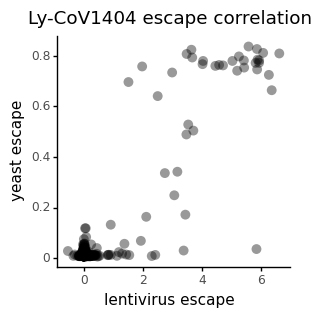

In [10]:
escape_corr=(
    ggplot(merged_DMS.loc[(merged_DMS['frac_models'] >=0.75)&( merged_DMS['times_seen'] >=3)&(merged_DMS['n_models'] >=3)]) +
    aes(x="escape_median", y="mut_escape") +
    geom_point(size=4, alpha=0.4, stroke = 0) + 
    theme_classic() +
    theme(figure_size=(3,3)) +
    labs(
        title = "Ly-CoV1404 escape correlation",
        x="lentivirus escape",
        y="yeast escape")
)

_ = escape_corr.draw()

_.savefig(f'{resultsdir}/escape_corr_yeast.pdf', bbox_inches='tight')
